In [3]:
from delphi.log.result_analysis import get_metrics, load_data
from pathlib import Path
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

In [4]:
run_name = "qwen_cross_instruct_pile_better"
layer = 18

In [5]:
scores_path = Path.cwd() / "results" / run_name / "scores"
latent_df, _ = load_data(scores_path, [f"layers.{layer}"])
latent_df

,text,distance,activating,prediction,probability,correct,activations,latent_idx,score_type,module
0,Rectanus Company.\nThe entire argument for th...,-1.0,False,True,None,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,detection,layers.18
1,"held in the company's possession, that the ex...",-1.0,False,True,None,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,detection,layers.18
2,"% free, we receive compensation for many of th...",-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,detection,layers.18
3,range) −10.25\* (−18.53 to −1.97) (−54 to +2,-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,detection,layers.18
4,% FBS and antibiotics. The rescued PCV3 virus ...,-1.0,False,False,None,True,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10000,detection,layers.18
...,...,...,...,...,...,...,...,...,...,...
158035,"00 gradient separation, as described in \[[@B1...",-1.0,False,True,None,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9995,detection,layers.18
158036,"={C}]\n [2,red,my label={D}]\n ...",2.0,True,True,None,True,"[0.0, 0.0, 0.0, 1.328125, 0.0, 0.0, 1.9375, 0....",9995,detection,layers.18
158037,"(FTLD). In human tauopathies, pathology progr...",8.0,True,False,None,False,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",9995,detection,layers.18
158038,2*d = 4*m + 16. Let s be (-4)/6*(-9)/d + 10. S...,-1.0,False,True,None,False,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9995,detection,layers.18


In [6]:
latent_df.latent_idx.nunique()

3958

In [7]:
processed_df = get_metrics(latent_df)
processed_df

,score_type,true_positives,true_negatives,false_positives,false_negatives,total_examples,total_positives,total_negatives,failed_count,precision,recall,f1_score,accuracy,true_positive_rate,true_negative_rate,false_positive_rate,false_negative_rate,positive_class_ratio,negative_class_ratio,auc
0,detection,43368,62008,16674,35625,157675,78993,78682,0,0.722294,0.549011,0.623843,0.668547,0.549011,0.788084,0.211916,0.450989,0.500986,0.499014,None


In [8]:
def prf(group):
    return pd.Series(
        {
            "precision": precision_score(
                group["activating"],
                group["prediction"],
                zero_division=0,  # or 1, depending on how you want to handle all-zero cases
            ),
            "recall": recall_score(
                group["activating"], group["prediction"], zero_division=0
            ),
            "f1": f1_score(group["activating"], group["prediction"], zero_division=0),
            "accuracy": accuracy_score(group["activating"], group["prediction"]),
        }
    )

df = latent_df.copy().dropna(subset=["activating", "prediction"])
df.activating = df.activating.astype(int)
df.prediction = df.prediction.astype(int)

metrics_by_pk = (
    df[["activating", "prediction", "latent_idx"]]
    .dropna(subset=["activating", "prediction"], axis=0)
    .groupby("latent_idx")
    .apply(prf)
    .reset_index()
)


/tmp/ipykernel_1774130/3625814076.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(prf)


In [10]:
# show most interpretable latents
metrics_by_pk.sort_values("accuracy", ascending=False)[:20]

,latent_idx,precision,recall,f1,accuracy
1520,12216,1.000000,1.00,1.000000,1.000
2206,18205,1.000000,1.00,1.000000,1.000
746,5933,1.000000,1.00,1.000000,1.000
596,4731,1.000000,1.00,1.000000,1.000
3415,28157,1.000000,1.00,1.000000,1.000
890,7123,0.952381,1.00,0.975610,0.975
2876,23717,1.000000,0.95,0.974359,0.975
1788,14710,1.000000,0.95,0.974359,0.975
3678,30307,1.000000,0.95,0.974359,0.975
2322,19179,1.000000,0.95,0.974359,0.975


In [110]:
pd.set_option("display.max_colwidth", None)
latent_df[["text", "activating"]]

,text,activating
0,"newly created belt by the WBC. The belt, valued at $1 million, is an exact replica of the current belt, except it has thousands of em",False
1,"* (co-offending is a social exchange whereby offenders receive material reward, e.g., payments, and immaterial reward, e.g., social",False
2,", namely germinal center B-cell-like (GCB), if presenting with expression features similar to germinal center cells, and activated B-cell-",False
3,ell Ellis)\nD.C. II: Da Capo II (Akane Hanasaki)\nEf: The First Tale. (Chihiro,True
4,"postoperatively. There appeared to be minimal bio-incorporation of the stent-grafts into the biliary duct wall, and there was no pronounced inflammatory response",True
...,...,...
252275,accounts for more than two per cent of that total. Court records show that Lancashire was unusual in the north of England for the frequency of its witch trials,False
252276,"[*Phys. Rev.*]{} [**B 94**]{}, 224418 (2016). Mazurenko, V. V., et al. [*Phys. Rev.*]{} [**",True
252277,fabrication of the stiffness-tunable GO/PAAm composite scaffolds and the effect of substrate stiffness on cell growth. As illustrated in [Scheme 1A,True
252278,"in the thermal energy range. Finally, the Vision chemical spectrometer will use crystal analyzers to study energy transfers into the epithermal range\n\nCEA",True


In [111]:
norms = pd.read_csv("norm_strengths.csv")

<Axes: xlabel='relative_norm', ylabel='f1'>

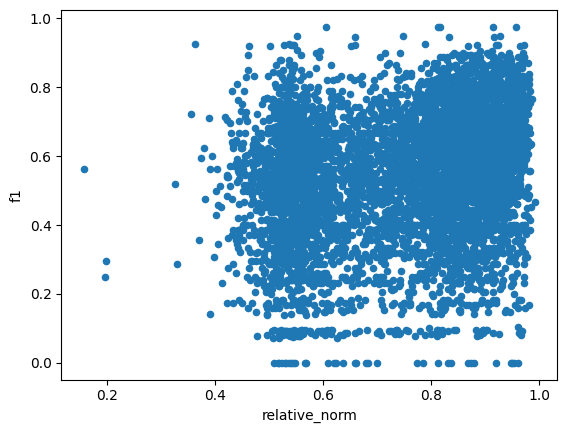

In [112]:
pd.merge(metrics_by_pk, norms, on="latent_idx").plot.scatter(x="relative_norm", y="f1")

In [113]:
right = True

h, l = 0.8, 0.3

if right:
    specific = pd.merge(metrics_by_pk, norms[norms["relative_norm"] >= h], on="latent_idx")
    other = pd.merge(
        metrics_by_pk,
        norms[(norms["relative_norm"] < h) & (norms["relative_norm"] > l)],
        on="latent_idx",
    )
else:
    specific = pd.merge(
        metrics_by_pk, norms[norms["relative_norm"] <= l], on="latent_idx"
    )
    other = pd.merge(
        metrics_by_pk,
        norms[(norms["relative_norm"] > l) & (norms["relative_norm"] < h)],
        on="latent_idx",
    )

In [114]:
print(len(specific))
specific.accuracy.mean()

3244


np.float64(0.6646027831601199)

In [115]:
print(len(other))
other.accuracy.mean()

3063


np.float64(0.6022853411687887)

In [12]:
metrics_by_pk["expl"] = metrics_by_pk.latent_idx.progress_map(
    lambda x: open(f"results/qwen_cross_pile_better/explanations/layers.18_latent{x}.txt").read()
)

100%|██████████| 3958/3958 [00:07<00:00, 517.04it/s]


In [16]:
s = metrics_by_pk.sample(10) # .sort_values("f1", ascending=False)[:20]

In [19]:
s

,latent_idx,precision,recall,f1,accuracy,expl
38,284,0.789474,0.75,0.769231,0.775,"""The token \""at\"" followed by \""your\"" or \""th..."
3944,32661,0.727273,0.40,0.516129,0.625,"""The token \""0\"" frequently appears in date an..."
530,4145,0.785714,0.55,0.647059,0.700,"""The token \""to\"" often precedes a verb or inf..."
1143,9257,0.846154,0.55,0.666667,0.725,"""The text contains references to specific iOS ..."
349,2647,1.000000,0.85,0.918919,0.925,"""The token sequence \""Copyright (C) <<->>\"" is..."
3150,26146,0.695652,0.80,0.744186,0.725,"""The text contains various scientific and tech..."
2639,21763,0.894737,0.85,0.871795,0.875,"""The token \""array\"" or variations thereof fre..."
897,7159,1.000000,0.50,0.666667,0.750,"""The text contains frequent references to bibl..."
2376,19629,0.888889,0.80,0.842105,0.850,"""The token \"":\"" is frequently used to introdu..."
3483,28757,0.611111,0.55,0.578947,0.600,"""The text contains various patterns related to..."


In [21]:
for i, e in enumerate(s.expl.tolist()):
    print(i, e)

0 "The token \"at\" followed by \"your\" or \"the\" is frequently used in legal and formal contexts to denote optional or conditional actions, permissions, or discretion."
1 "The token \"0\" frequently appears in date and time formats, while \"3\" and \"6\" are common in specific numerical sequences or identifiers. The token \"pm\" indicates a time in the afternoon, and \"struct\" is often used in C programming to define a structure. The token \"to\" is part of phrases indicating purpose or direction."
2 "The token \"to\" often precedes a verb or infinitive, \"the\" frequently introduces a noun, and \"way\" or \"steps\" is used to describe a method or process. Additionally, \"consider\" and \"tried\" indicate reflection or effort, while \"attractive\" and \"unavoidable\" describe qualities or inevitabilities."
3 "The text contains references to specific iOS and macOS versions, Android versions, and Swift versions, indicating discussions about software updates and improvements in mobile